In [20]:
import json

with open("data/Dataset/Train/annotations.json", "r") as f:
    annotations = json.load(f)

In [21]:
amount_of_offences = {}

for action_id, action_info in annotations["Actions"].items():
    action_name = f"action_{action_id}"
    offence = action_info["Offence"]

    if offence not in amount_of_offences:
        amount_of_offences[offence] = 0
    amount_of_offences[offence] += 1

In [22]:
print(json.dumps(amount_of_offences, indent=4))

{
    "Offence": 2495,
    "No offence": 324,
    "Between": 96,
    "": 1
}


In [23]:
from IPython.display import Video

skip = 3

for action_id, action_info in annotations["Actions"].items():
    action_name = f"action_{action_id}"
    offence = action_info["Offence"]

    if offence == "No offence":
        if skip > 0:
            skip -= 1
            continue
        print(json.dumps(action_info, indent=4))
        for clip_info in action_info["Clips"]:
            video_path = f"data/{clip_info['Url']}.mp4"
            display(Video(video_path, width=1920))
        
        break

{
    "UrlLocal": "england_epl\\2014-2015\\2015-02-22 - 19-15 Southampton 0 - 2 Liverpool",
    "Offence": "No offence",
    "Contact": "With contact",
    "Bodypart": "Under body",
    "Upper body part": "",
    "Action class": "Tackling",
    "Severity": "",
    "Multiple fouls": "",
    "Try to play": "Yes",
    "Touch ball": "Yes",
    "Handball": "No handball",
    "Handball offence": "",
    "Clips": [
        {
            "Url": "Dataset/Train/action_33/clip_0",
            "Camera type": "Main camera center",
            "Timestamp": 1066089,
            "Replay speed": 1.0
        },
        {
            "Url": "Dataset/Train/action_33/clip_1",
            "Camera type": "Close-up player or field referee",
            "Timestamp": 1081500,
            "Replay speed": 2.4
        }
    ]
}


In [24]:
import cv2

def convert_to_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_FPS, 25)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (1920, 1080))
        frames.append(frame)
    cap.release()
    return frames

In [33]:
import os
import random

MAX_AMOUNT_PER_CLASS = 200

os.makedirs("data/frames/no_offence", exist_ok=True)
os.makedirs("data/frames/offence", exist_ok=True)

randomly_ordered_actions = list(annotations["Actions"].items())
random.seed(42)
random.shuffle(randomly_ordered_actions)

amount_of_videos_processed = {}
for action_id, action_info in randomly_ordered_actions:
    action_name = f"action_{action_id}"
    offence = action_info["Offence"]

    if amount_of_videos_processed.get(offence, 0) >= MAX_AMOUNT_PER_CLASS:
        continue

    # Create directory for this specific action
    if offence == "No offence":
        base_dir = "data/frames/no_offence"
    elif offence == "Offence":
        base_dir = "data/frames/offence"
    else:
        continue

    os.makedirs(f"{base_dir}/{action_name}/img1", exist_ok=True)
    
    frames = convert_to_frames(f"data/Dataset/Train/{action_name}/clip_0.mp4")
    
    for i, frame in enumerate(frames):
        cv2.imwrite(f"{base_dir}/{action_name}/img1/{(i+1):06d}.jpg", frame)

    if offence not in amount_of_videos_processed:
        amount_of_videos_processed[offence] = 0
    amount_of_videos_processed[offence] += 1

In [30]:
import cv2
import numpy as np
from IPython.display import Image


# Load the video file
video_path = "data/Dataset/Train/action_33/clip_0.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"frame_count: {frame_count}")

frames_to_skip_start = 55
frames_to_skip_end = 0

frames = []
for i in range(frames_to_skip_start, frame_count - frames_to_skip_end):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)

cap.release()

# Check if frames were extracted
len(frames), (frame_width, frame_height)


frame_count: 126


(71, (398, 224))

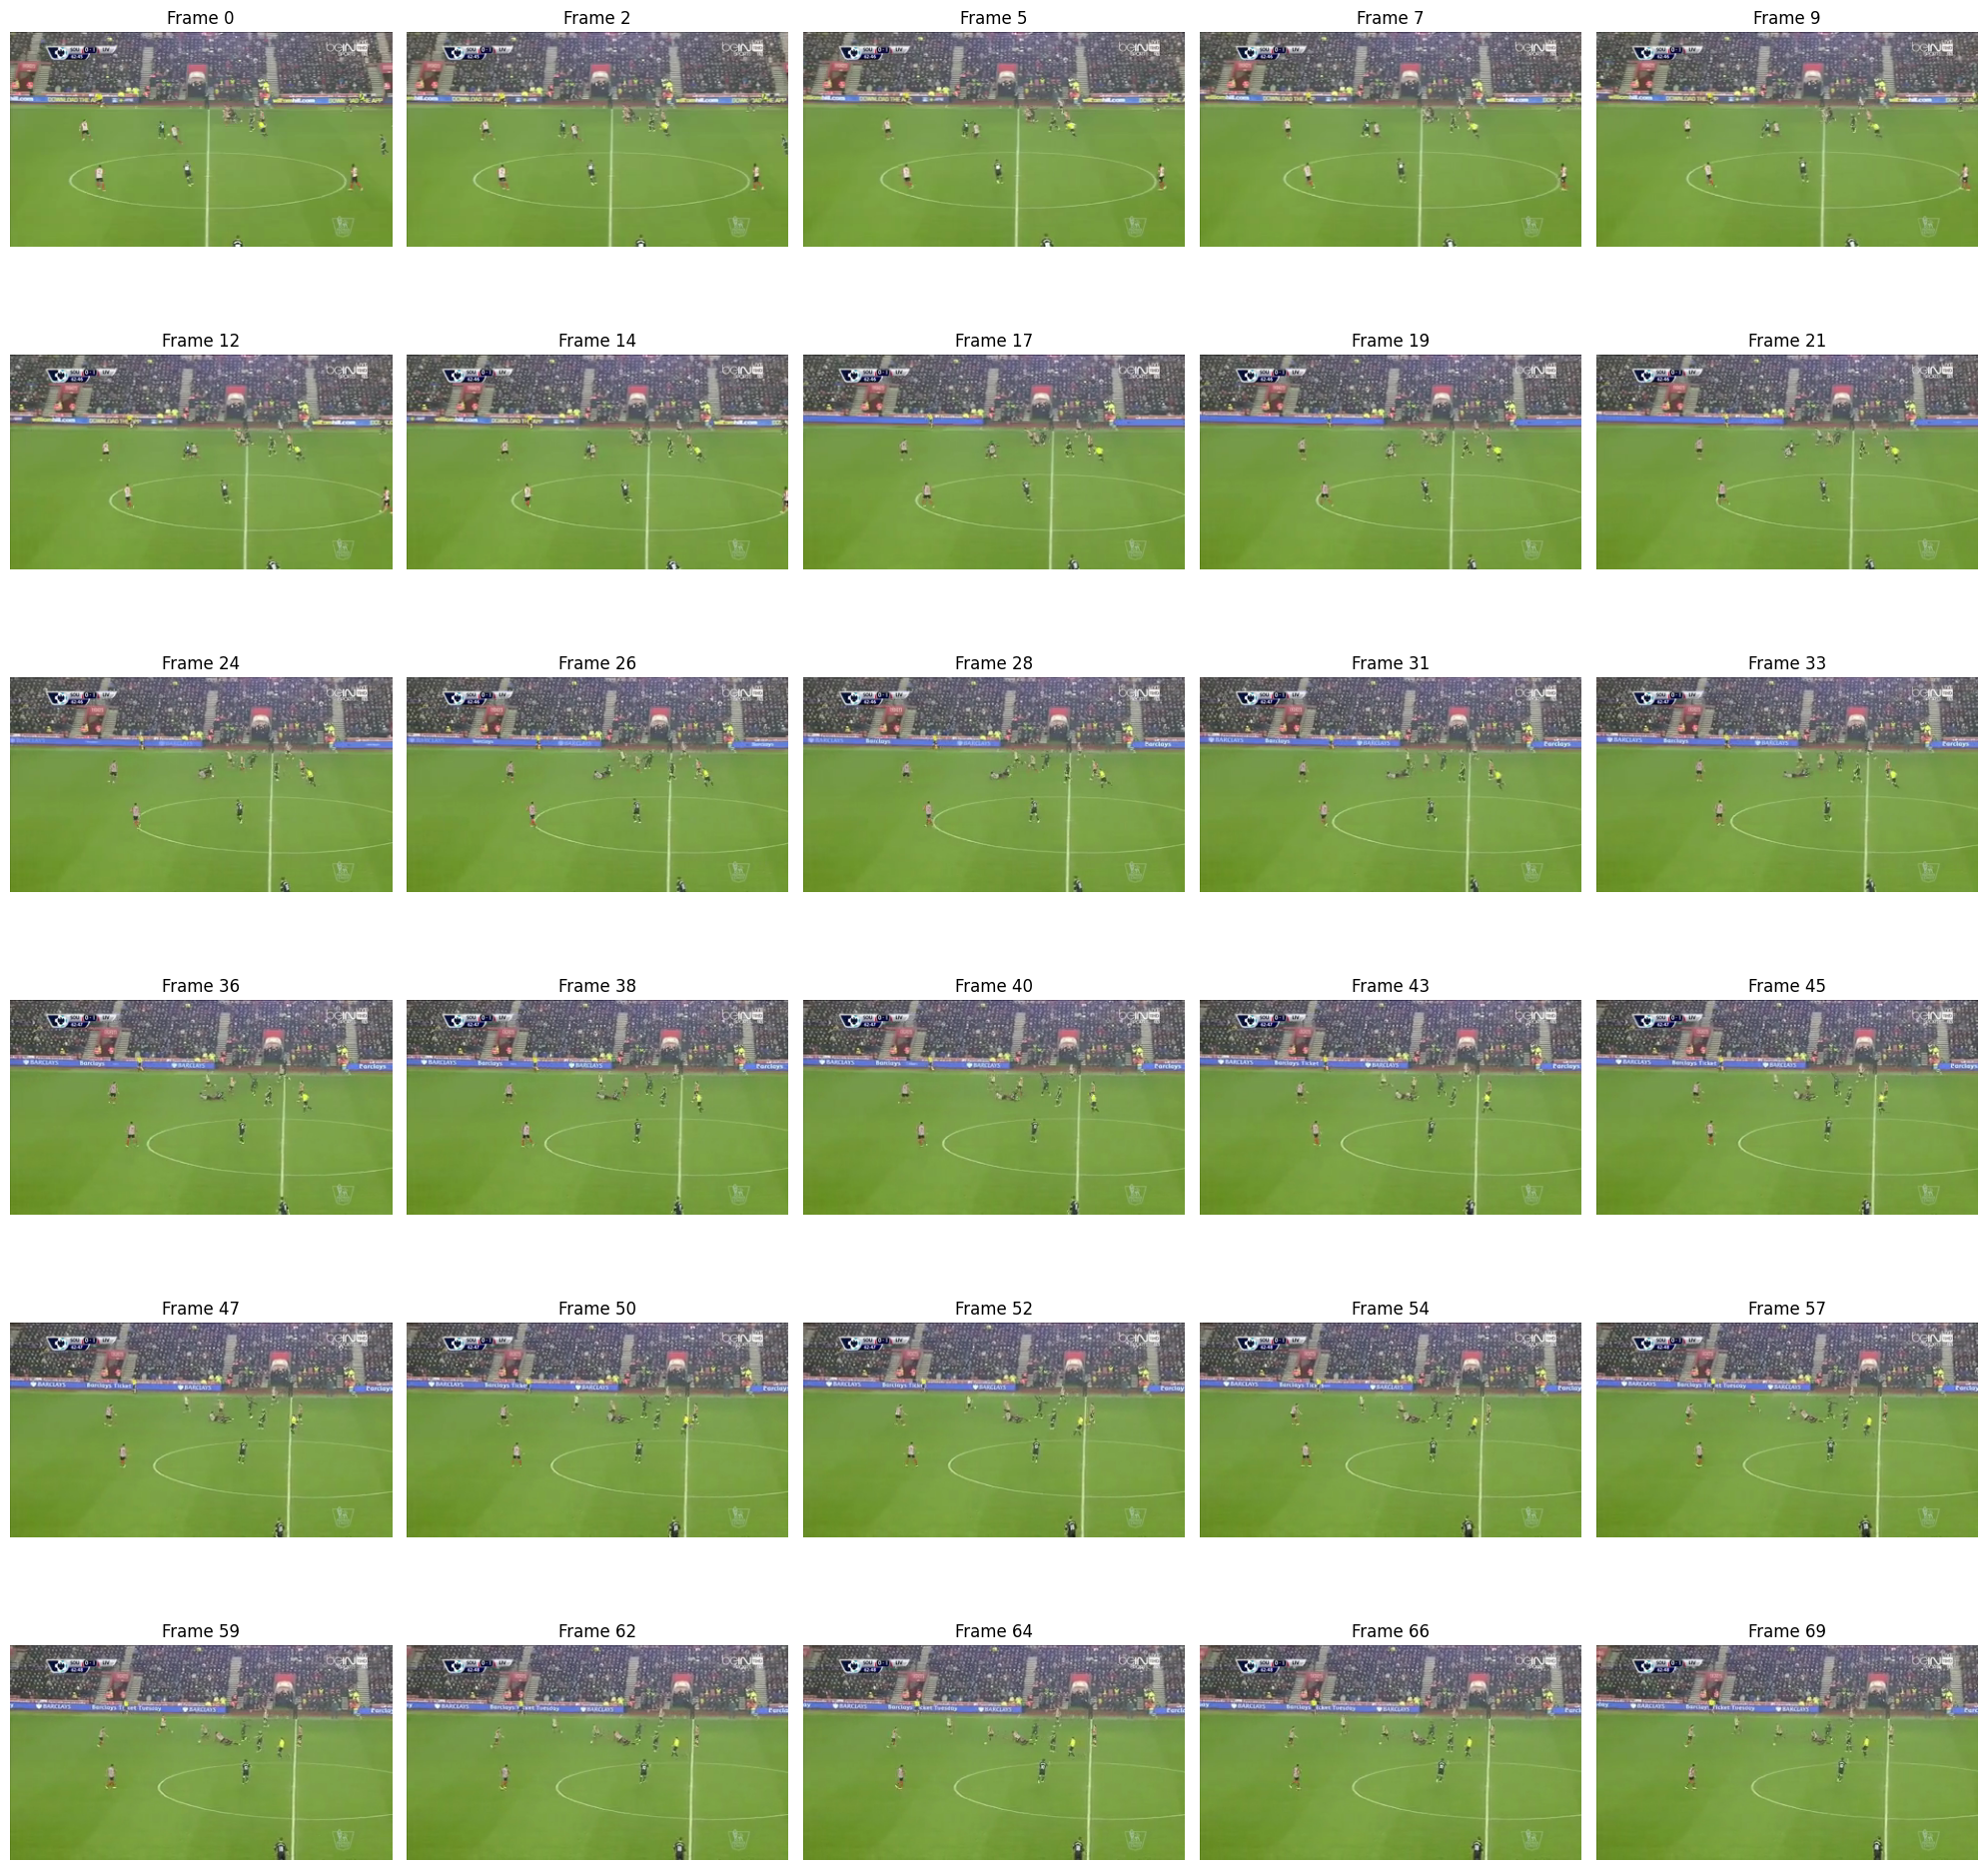

In [34]:
import matplotlib.pyplot as plt

amount_to_display = 30
sample_interval = len(frames) / amount_to_display

# Display 25 extracted frames for visual inspection
num_display = min(amount_to_display, len(frames))  # Display up to 25 frames
rows = amount_to_display//5 + 1 if amount_to_display % 5 != 0 else amount_to_display//5
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i in range(num_display):
    frame_idx = min(round(i * sample_interval), len(frames) - 1)
    if i < len(frames):
        axes[i].imshow(cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title(f"Frame {frame_idx}")
    else:
        # Hide unused subplots if fewer than 25 frames
        axes[i].axis("off")

plt.tight_layout()
plt.show()

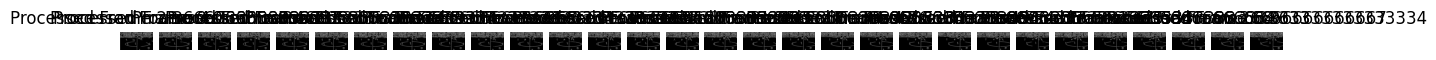

In [33]:
 # Convert frames to grayscale and apply edge detection to highlight the ball and players
processed_frames = []

for frame in frames:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Edge detection
    processed_frames.append(edges)

# Display processed frames for ball detection assessment
fig, axes = plt.subplots(1, num_display, figsize=(15, 5))

for i in range(num_display):
    axes[i].imshow(processed_frames[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Processed Frame {i * sample_interval}")

plt.show()